In [3]:
import gym

import matplotlib.pyplot as plt
import random
import numpy as np
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15, 8)
legend_fontsize = 16

from matplotlib import rc
rc('font', **{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

In [6]:
from collections import defaultdict
import tqdm

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [7]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        # спасибо Артёму Цуканову
        print('╭', ('───┬' * self.n_cols)[:-1], '╮', sep='')
        for i in range(0, self.n_rows):
            if i != 0:
                print('├', ('───┼' * self.n_cols)[:-1], '┤', sep='')
            out = '│ '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' │ '
            print(out, sep='')
        print('╰', ('───┴' * self.n_cols)[:-1], '╯', sep='')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [8]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq,
                        horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center',
                        verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center',
                        verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.


### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [ ]:
# NO!
def Q_learning_episode(env, pi_1, pi_2, alpha=0.009, epsilon=0.1, gamma=1.0):
    env.reset()
    board_hash, emptySpaces, curTurn = env.getState()
    reward = 0
    done = False
    pi_1_prev_board = None
    pi_1_prev_a = None
    pi_2_prev_board = None
    pi_2_prev_a = None
    while not done:
        if curTurn == 1: # Ходят крестики
            if board_hash in pi_1.Q and np.random.random() > epsilon: # знакомое состояние + идем по стратегии, а не exploration
                idx = np.argmax(pi_1.Q[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces)) # играем случайно (или незнакомое состояние, или exploration)
                if board_hash not in pi_1.Q: # Если состояние не знакомое - добавляем его
                    pi_1.Q[board_hash] = np.zeros(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
            # Теперь мы получили следующее состояние для обучения стратегии ноликов
            if pi_2_prev_board is not None:
                gamma_term = gamma * np.max(pi_2.Q[board_hash_prime]) if board_hash_prime in pi_2.Q else 0
                pi_2.Q[pi_2_prev_board][pi_2_prev_a] = pi_2.Q[pi_2_prev_board][pi_2_prev_a] + alpha * (-reward + gamma_term - pi_2.Q[pi_2_prev_board][pi_2_prev_a])
            # Если крестики победили этим ходом, то нужно запомнить, что предыдущее состояние для нас было удачное
            if reward == 1:
                  pi_1.Q[board_hash][idx] = reward
            pi_1_prev_board = board_hash
            pi_1_prev_a = idx
        elif curTurn == -1: # Ходят нолики
            if board_hash in pi_2.Q and np.random.random() > epsilon:
                idx = np.argmax(pi_2.Q[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
                if board_hash not in pi_2.Q:
                    pi_2.Q[board_hash] = np.zeros(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
            # Теперь мы получили следующее состояние для обучения стратегии крестиков
            if pi_1_prev_board is not None:
                gamma_term = gamma * np.max(pi_1.Q[board_hash_prime]) if board_hash_prime in pi_1.Q else 0
                pi_1.Q[pi_1_prev_board][pi_1_prev_a] = pi_1.Q[pi_1_prev_board][pi_1_prev_a] + alpha * (reward + gamma_term - pi_1.Q[pi_1_prev_board][pi_1_prev_a])
            # Если мы победили этим ходом, то нужно запомнить, что предыдущее состояние для нас было удачное
            if reward == -1:
                pi_2.Q[board_hash][idx] = -reward
            pi_2_prev_board = board_hash
            pi_2_prev_a = idx
        else:
            raise Exception('There is only 2 players!')
        
        board_hash, emptySpaces, curTurn = board_hash_prime, emptySpaces_prime, curTurn_prime

In [45]:
class Agent:
    def __init__(self, action_size):
        pass 

    def act(self, state):
        pass

class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.Q = defaultdict(lambda: np.zeros(action_size))
        
        self.s = "start"
        self.a = None

    def update_Q(self, reward, s, a):
        self.Q[self.s][self.a] += ALPHA * (reward + GAMMA * np.max(self.Q[s])
                                 - self.Q[self.s][self.a])
        self.a = a
        self.s = s

    def act(self, state):
        return np.argmax(self.Q[state])
    

In [75]:
def available_actions(state):
    array = np.array(list(state))
    return np.where(array == '1')[0]

def not_available_actions(state):
    array = np.array(list(state))
    return np.where(array != '1')[0]

def play_game(env, agent1=None, agent2=None, print_board=False):
    env.reset()
    state, empty_spaces, turn = env.getState()
    done = False
    player = 1
    while not done:
        
        if player == 1:
            if agent1 is None:
                action = random.choice(available_actions(state))
            else:
                action = agent1.act(state)
        elif player == -1:
            if agent2 is None:
                action = random.choice(available_actions(state))
            else:
                action = agent2.act(state)
        else:
            raise Exception("player not 1 or -1")
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        if print_board:
            env.printBoard()
        player = player * -1
                    
    if reward == 1:
        result = (1, 0)
    elif reward == -1:
        result = (0, 1)
    else:
        result = (0, 0)
    return result

def evaluate(env, agent1=None, agent2=None, n=1000, disable_tqdm=False):
    rewards1 = []
    rewards2 = []
    for _ in tqdm.notebook.tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game(env, agent1, agent2, print_board=False)
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    return r1, r2, no_winner

In [84]:
def Q_learning_episode(env, agent1, agent2):
    env.reset()
    s, empty_spaces, turn = env.getState()
    agents = (agent1, agent2)
    done = False
    agent_idx = 0
    reward = 0
    while not done:
        agent = agents[agent_idx]
        agent.Q[s][not_available_actions(s)] = -1e4
        if random.random() > EPSILON:
            a = agent.act(s) 
        else:
            a = random.choice(available_actions(s))
        agent.update_Q(reward, s, a)
        agent_idx = 1 - agent_idx
        (s, empty_spaces, turn), reward, done, _ = env.step(env.action_from_int(a))
    if reward < -1:
        agent.update_Q(reward, s, a)
    else:
        agent1.update_Q(reward, s, a)
        agent2.update_Q(-reward, s, a)
    

In [85]:
def Q_learning_train(env, agent1, agent2, total_episodes=100_000, n_check=100):
    res_p1 = []
    res_p2 = []
    check_list = []

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        Q_learning_episode(env, agent1, agent2)
        if n % n_check == 0:
            reward_p1 = evaluate(env, agent1=agent1, disable_tqdm=True)[0]
            reward_p2 = evaluate(env, agent2=agent2, disable_tqdm=True)[1]
            res_p1.append(reward_p1)
            res_p2.append(reward_p2)
            check_list.append(n)
    return agent1, agent2, res_p1, res_p2, check_list

In [32]:
for n in tqdm.tqdm_notebook(range(2)):
    None

<ipython-input-32-63a48a760c65>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm.tqdm_notebook(range(2)):


  0%|          | 0/2 [00:00<?, ?it/s]

In [86]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
game_hash, empty_spaces, _ = env.getState()

In [87]:
action_size = len(empty_spaces)
agent_X = DeterministicPolicyAgent(action_size)
agent_O = DeterministicPolicyAgent(action_size)
EPSILON = 0.5
ALPHA = 0.01
GAMMA = 1
res_Q = Q_learning_train(env, agent_X, agent_O, total_episodes=100_000)
agent_X, agent_O, res_p1, res_p2, check_list = res_Q

  0%|          | 0/100000 [00:00<?, ?it/s]

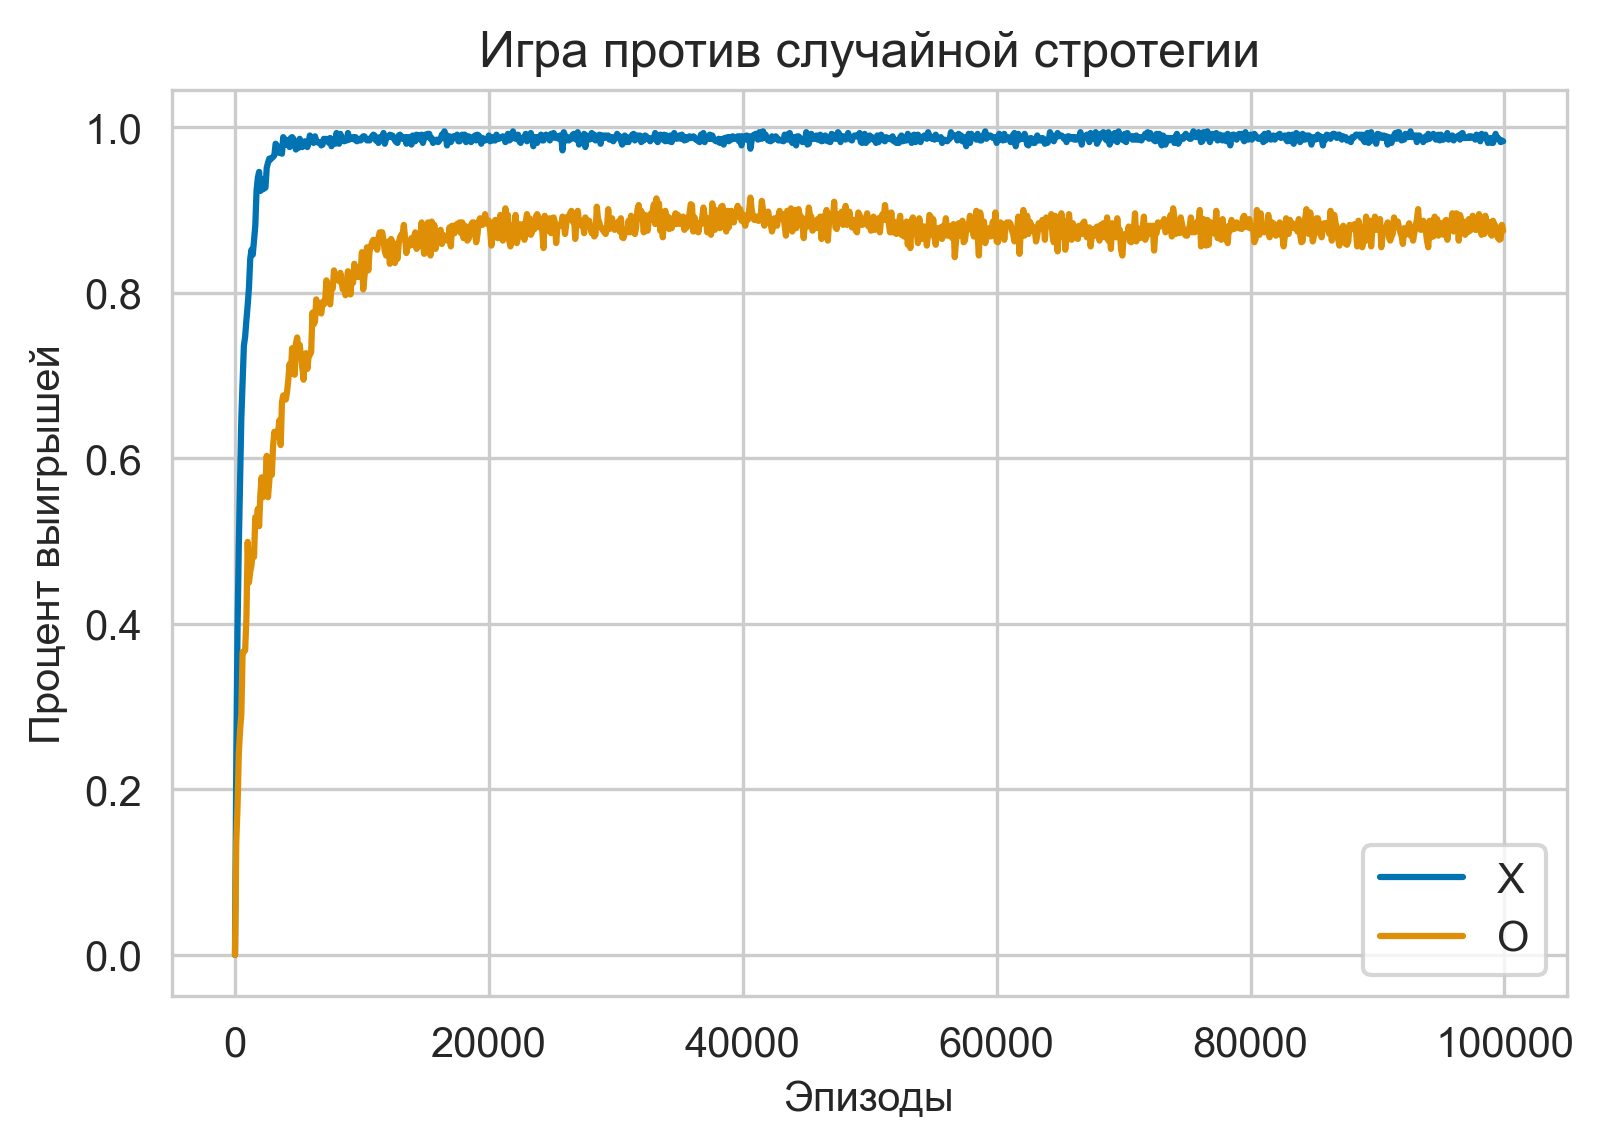

In [88]:
plt.title('Игра против случайной стротегии')
plt.xlabel('Эпизоды')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(check_list, res_p1, label="X")
plt.plot(check_list, res_p2, label="O")
plt.legend()
plt.show()

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [89]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()
game_hash, empty_spaces, _ = env.getState()

In [90]:
action_size = len(empty_spaces)
agent_X = DeterministicPolicyAgent(action_size)
agent_O = DeterministicPolicyAgent(action_size)
EPSILON = 0.6
ALPHA = 0.05
GAMMA = 1
res_Q = Q_learning_train(env, agent_X, agent_O, total_episodes=4_000_000, n_check=4_000)
agent_X, agent_O, res_p1, res_p2, check_list = res_Q

  0%|          | 0/4000000 [00:00<?, ?it/s]

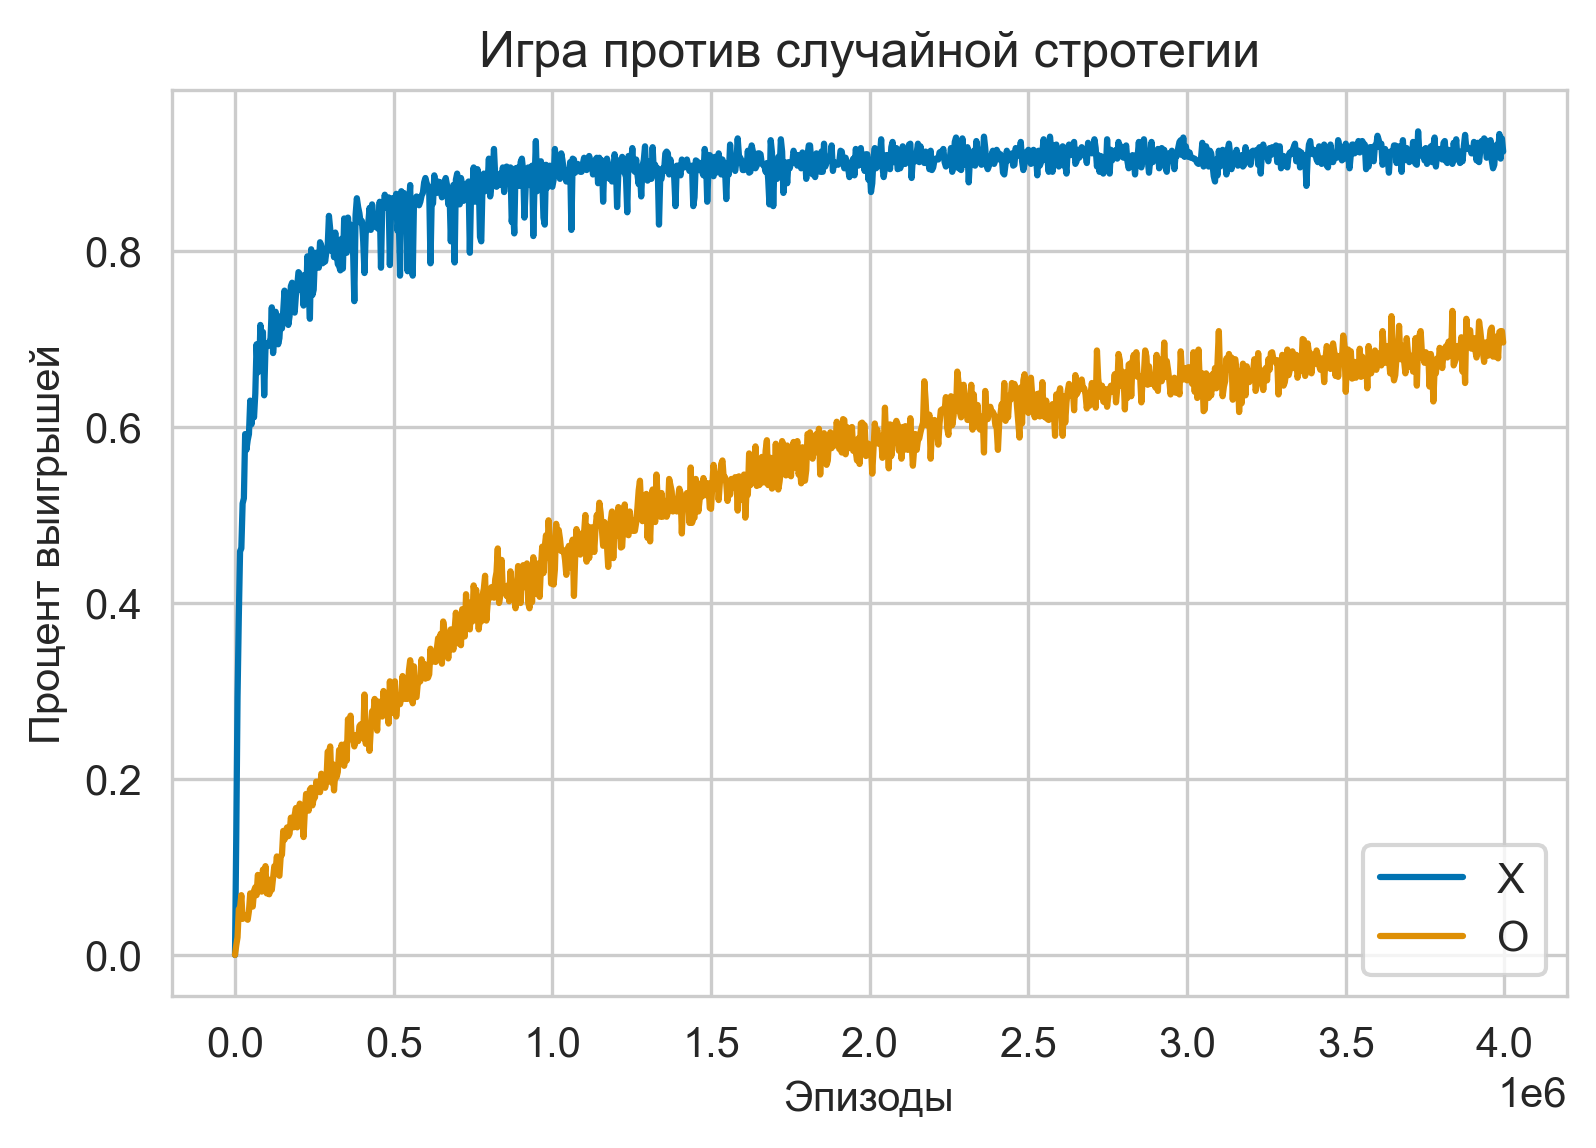

In [91]:
plt.title('Игра против случайной стротегии')
plt.xlabel('Эпизоды')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(check_list, res_p1, label="X")
plt.plot(check_list, res_p2, label="O")
plt.legend()
plt.show()